In [1]:
import pandas as pd
import json
import requests
import matplotlib.pylab as plt

from itertools import groupby
from datetime import datetime as dt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\P276495\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
METRICS_ALL = 'accessors,new_technical_debt,blocker_violations,conditions_to_cover,new_it_conditions_to_cover,new_conditions_to_cover,bugs,burned_budget,business_value,class_complexity_distribution,classes,code_smells,comment_lines,commented_out_code_lines,comment_lines_density,comment_lines_data,complexity,class_complexity,file_complexity,function_complexity,complexity_in_classes,complexity_in_functions,branch_coverage,new_it_branch_coverage,new_branch_coverage,conditions_by_line,confirmed_issues,coverage,new_it_coverage,coverage_line_hits_data,new_coverage,covered_conditions_by_line,critical_violations,last_commit_date,directories,duplicated_blocks,new_duplicated_blocks,duplicated_files,duplicated_lines,duplicated_lines_density,new_duplicated_lines,new_duplicated_lines_density,duplications_data,effort_to_reach_maintainability_rating_a,executable_lines_data,false_positive_issues,file_complexity_distribution,files,function_complexity_distribution,functions,generated_lines,generated_ncloc,info_violations,violations,it_conditions_to_cover,it_branch_coverage,it_conditions_by_line,it_coverage,it_coverage_line_hits_data,it_covered_conditions_by_line,it_line_coverage,it_lines_to_cover,it_uncovered_conditions,it_uncovered_lines,line_coverage,new_it_line_coverage,new_line_coverage,lines,ncloc,ncloc_language_distribution,new_lines,lines_to_cover,new_it_lines_to_cover,new_lines_to_cover,sqale_rating,new_maintainability_rating,major_violations,minor_violations,ncloc_data,new_blocker_violations,new_bugs,new_code_smells,new_critical_violations,new_info_violations,new_violations,new_major_violations,new_minor_violations,new_vulnerabilities,open_issues,overall_conditions_to_cover,new_overall_conditions_to_cover,overall_branch_coverage,new_overall_branch_coverage,overall_conditions_by_line,overall_coverage,overall_coverage_line_hits_data,new_overall_coverage,overall_covered_conditions_by_line,overall_line_coverage,new_overall_line_coverage,overall_lines_to_cover,new_overall_lines_to_cover,overall_uncovered_conditions,new_overall_uncovered_conditions,overall_uncovered_lines,new_overall_uncovered_lines,quality_profiles,projects,public_api,public_documented_api_density,public_undocumented_api,quality_gate_details,alert_status,reliability_rating,new_reliability_rating,reliability_remediation_effort,new_reliability_remediation_effort,reopened_issues,security_rating,new_security_rating,security_remediation_effort,new_security_remediation_effort,skipped_tests,development_cost,statements,team_size,sqale_index,sqale_debt_ratio,new_sqale_debt_ratio,uncovered_conditions,new_it_uncovered_conditions,new_uncovered_conditions,uncovered_lines,new_it_uncovered_lines,new_uncovered_lines,test_data,test_execution_time,test_errors,test_failures,test_success_density,tests,vulnerabilities,wont_fix_issues'
METRICS_NOTNULL = 'blocker_violations,bugs,classes,code_smells,comment_lines,comment_lines_density,complexity,class_complexity,file_complexity,function_complexity,complexity_in_classes,complexity_in_functions,confirmed_issues,critical_violations,last_commit_date,directories,duplicated_blocks,duplicated_files,duplicated_lines,duplicated_lines_density,effort_to_reach_maintainability_rating_a,false_positive_issues,file_complexity_distribution,files,function_complexity_distribution,functions,info_violations,violations,lines,ncloc,ncloc_language_distribution,sqale_rating,major_violations,minor_violations,open_issues,quality_profiles,quality_gate_details,alert_status,reliability_rating,reliability_remediation_effort,reopened_issues,security_rating,security_remediation_effort,development_cost,statements,sqale_index,sqale_debt_ratio,vulnerabilities,wont_fix_issues'
METRICS_NOTNULL_NOTSTRING = 'blocker_violations,bugs,classes,code_smells,comment_lines,comment_lines_density,complexity,class_complexity,file_complexity,function_complexity,complexity_in_classes,complexity_in_functions,confirmed_issues,critical_violations,last_commit_date,directories,duplicated_blocks,duplicated_files,duplicated_lines,duplicated_lines_density,effort_to_reach_maintainability_rating_a,false_positive_issues,files,functions,info_violations,violations,lines,ncloc,major_violations,minor_violations,open_issues,reliability_remediation_effort,reopened_issues,security_remediation_effort,development_cost,statements,sqale_index,sqale_debt_ratio,vulnerabilities,wont_fix_issues'
METRICS_NOTNULL_NOTSTRING_NOTLASTITEMVALUE = 'blocker_violations,bugs,classes,code_smells,comment_lines,comment_lines_density,complexity,class_complexity,file_complexity,function_complexity,confirmed_issues,critical_violations,last_commit_date,directories,duplicated_blocks,duplicated_files,duplicated_lines,duplicated_lines_density,effort_to_reach_maintainability_rating_a,false_positive_issues,files,functions,info_violations,violations,lines,ncloc,major_violations,minor_violations,open_issues,reliability_remediation_effort,reopened_issues,security_remediation_effort,development_cost,statements,sqale_index,sqale_debt_ratio,vulnerabilities,wont_fix_issues'
METRICS_MTD = 'code_smells,bugs,classes,lines,ncloc,sqale_index,violations,blocker_violations,critical_violations,major_violations,minor_violations'
METRICS = METRICS_MTD
METRICS_LIST = METRICS.split(',')
metrics_list_length = len(METRICS_LIST)

In [4]:
class CommitStatsFile:
    def __init__(self, fileName, additions, deletions, changes, status, commitDate):
        self.fileName = fileName
        self.additions = float(additions)
        self.deletions = float(deletions)
        self.changes = float(changes)
        self.status = status
        self.commitDate = commitDate
        
    def __repr__(self):
        return "<CommitStatsFile fileName:%s additions:%s deletions:%s changes:%s status:%s commitDate:%s>" % (self.fileName, self.additions, self.deletions, self.changes, self.status, self.commitDate)

    def __str__(self):
        return "From str method of CommitStatsFile: fileName:%s additions:%s deletions:%s changes:%s status:%s commitDate:%s>" % (self.fileName, self.additions, self.deletions, self.changes, self.status, self.commitDate)

HETZNER_IP = '176.9.137.234'
UOM_PC_IP = '195.251.210.136'
UOM_DB_IP = '195.251.210.166'
RUG_IP = '129.125.5.170'

SONARQUBE_IP = HETZNER_IP

SONARQUBE_PORT = '9000'
REST_API_PORT = '8080'

COMMIT_STATS_API_URL = '/GitHubCommitStatsRest/webresources/commitstatsfiles/repo/'
COMMIT_STATS_API_CACHE_URL = '/GitHubCommitStatsCache/webresources/commitsstats/json/'
REST_URL = COMMIT_STATS_API_CACHE_URL

PROTOCOL = 'http://'

class GitHubProject:
    def __init__(self, repo_id, owner, repo, language, sonarqube_ip=SONARQUBE_IP, rest_api_ip = UOM_PC_IP):
        self.repo_id = repo_id
        self.owner = owner
        self.repo = repo
        self.language = language
        self.sonarqube_ip = sonarqube_ip
        self.rest_api_ip = rest_api_ip
        self.sonarqube_project_key = self.owner+':'+self.repo
        self.rest_key = self.owner+'/'+self.repo
        self.timemachine_metrics_url = self.sonarqube_ip + ':' + SONARQUBE_PORT + '/api/'+ 'timemachine?' + 'resource=' + self.sonarqube_project_key + '&metrics='
        self.commit_stats_url = PROTOCOL + self.rest_api_ip + ':' + REST_API_PORT + REST_URL + str(self.repo_id)

In [5]:
def get_repos():
    repos = []
    
    repos.append(GitHubProject(160994,'apache','sling','java'))
    repos.append(GitHubProject(206317,'apache','camel','java'))
#     repos.append(GitHubProject(206350,'apache','cayenne','java'))
#     repos.append(GitHubProject(206368,'apache','poi','java'))
#     repos.append(GitHubProject(206378,'apache','commons-lang'))
#     repos.append(GitHubProject(206424,'apache','cassandra','java'))
#     repos.append(GitHubProject(206483,'apache','maven','java'))
#     repos.append(GitHubProject(322018,'apache','aries','java'))
#     repos.append(GitHubProject(605999,'twitter','flockdb','scala'))
#     repos.append(GitHubProject(688352,'apache','jmeter','java'))
#     repos.append(GitHubProject(892275,'square','retrofit','java'))
#     repos.append(GitHubProject(1148753,'spring-projects','spring-framework','java'))
#     repos.append(GitHubProject(1463755,'spring-projects','spring-amqp-samples','java'))
#     repos.append(GitHubProject(1553787,'eclipse','egit','java'))
#     repos.append(GitHubProject(1553790,'eclipse','jgit','java'))
#     repos.append(GitHubProject(1936771,'google','truth','java'))
#     repos.append(GitHubProject(2108481,'spring-projects','spring-security-oauth','java'))
#     repos.append(GitHubProject(2153096,'apache','sqoop','java'))
#     repos.append(GitHubProject(2211243,'apache','kafka','java'))
#     repos.append(GitHubProject(2304277,'spring-projects','spring-roo','java'))
#     repos.append(GitHubProject(2340549,'playframework','playframework','java'))
#     repos.append(GitHubProject(2442457,'apache','ambari','java'))
#     repos.append(GitHubProject(2888818,'scala','scala','scala'))
#     repos.append(GitHubProject(5152285,'square','okhttp','java'))
#     repos.append(GitHubProject(6296790,'spring-projects','spring-boot','java'))
#     repos.append(GitHubProject(7437073,'apache','jena','java'))
#     repos.append(GitHubProject(7508411,'ReactiveX','RxJava','java'))
#     repos.append(GitHubProject(7691631,'docker','docker','go'))
#     repos.append(GitHubProject(10230369,'google','auto','java'))
#     repos.append(GitHubProject(15928650,'apache','struts','java'))
#     repos.append(GitHubProject(16389681,'google','j2objc','java'))
#     repos.append(GitHubProject(16977479,'apache','cxf','java'))
#     repos.append(GitHubProject(17165658,'apache','spark','scala'))
#     repos.append(GitHubProject(18845024,'google','closure-compiler','java'))
#     repos.append(GitHubProject(20300177,'google','guava','java'))
#     repos.append(GitHubProject(20587599,'apache','flink','java'))
#     repos.append(GitHubProject(23418517,'apache','hadoop','java'))
#     repos.append(GitHubProject(27911088,'apache','nifi','java'))
#     repos.append(GitHubProject(50904245,'apache','beam','java'))
#     repos.append(GitHubProject(51905353,'apache','arrow','java'))
#     repos.append(GitHubProject(206317,'apache','ignite','java'))
    
    return repos

def endswith(file_name, suffix):
    return file_name.lower().endswith((suffix))

def get_rest_response(rest_url):
    response = requests.get(rest_url)
    return json.loads(response.text)

def get_cells(json_data):
    return json_data[0]['cells']  # cells - metric values

def get_colls(json_data):
    return json_data[0]['cols']  # cols - Metrcs

def get_no_of_commits(cells):
    return len(cells)

def getCommitStatsFilesList(commitStatsFiles):
    commitStatsFilesList = []
    for item in commitStatsFiles:
        commitStatsFilesList.append(CommitStatsFile(item.get('fileName'), item.get('additions'), item.get('deletions'), item.get('changes'), item.get('status'), jsonDate_to_date(item.get('commitDate'))))
    return commitStatsFilesList

def get_date(date):
    return pd.Timestamp(date).date()

def get_min_date(commitStatsFiles):
    return get_date(jsonDate_to_date(commitStatsFiles[0].get('commitDate')))

def get_max_date(commitStatsFiles):
    return get_date(jsonDate_to_date(commitStatsFiles[len(commitStatsFiles) - 1].get('commitDate')))

def get_date_range_index(min_project_date, max_project_date):
    return pd.date_range(start=min_project_date, end=max_project_date, freq='D')

def draw_secondary_log_axis(df, secondary_column):
    ax = df.plot(secondary_y=secondary_column,figsize=(15,10))
    ax2 = ax.twinx()
    ax2.set_yscale('log')
    plt.show()
    
def jsonDate_to_date(strDate):
    d = '/Date('+str(strDate)+')/'
    return dt.fromtimestamp(float(d.split('(')[1][:-5])).strftime('%Y-%m-%d %H:%M:%S')

def create_the_data_frame(commitStatsFiles, language='java'):
    commitStatsFilesList = getCommitStatsFilesList(commitStatsFiles)

    min_project_date = get_min_date(commitStatsFiles)
    max_project_date = get_max_date(commitStatsFiles)

    date_range_index = get_date_range_index(min_project_date, max_project_date)
    df = pd.DataFrame(index=date_range_index)
    groups = groupby(commitStatsFilesList, lambda csf: (get_date(csf.commitDate)))

    files_added = pd.Series(index=date_range_index)
    modified = pd.Series(index=date_range_index)
    removed = pd.Series(index=date_range_index)
    renamed = pd.Series(index=date_range_index)
    additions = pd.Series(index=date_range_index)
    deletions = pd.Series(index=date_range_index)
    changes = pd.Series(index=date_range_index)

    for key, group in groups:
        grp = list(group)

        files_added[key] = 0
        modified[key] = 0
        removed[key] = 0
        renamed[key] = 0
        additions[key] = 0
        deletions[key] = 0
        changes[key] = 0
        for item in grp:
            if (endswith(item.fileName, '.'+language)):
                if(item.status == 'added'):
                    files_added[key] += 1
                elif(item.status == 'modified'):
                    modified[key] += item.changes

                    additions[key] += item.additions
                    deletions[key] += item.deletions
                    changes[key] += item.changes
                elif(item.status == 'removed'):
                    removed[key] += item.deletions
                elif(item.status == 'renamed'):
                    renamed[key] += item.changes

    df['files_added'] = files_added
    df['additions'] = additions
    df['deletions'] = deletions
    df['changes'] = changes
    df['modified'] = modified
    df['removed'] = removed
    df['renamed'] = renamed
    
    return df

def do_commit_analysis(gh_project, cache = True):
    print(gh_project.repo)
    response = get_rest_response(gh_project.commit_stats_url)
    commitStatsFiles = response
    if (not (cache)):
        commitStatsFiles = ['commitStatsFiles']
    
    df = create_the_data_frame(commitStatsFiles, gh_project.language)
    
    df.fillna(0, inplace=True)

    df2 = df[['files_added','changes']]
    df3=df2.rolling(window=30,center=False).sum()
    df4=df3.rolling(window=90,center=False).mean()
    df5=df3.rolling(window=90,center=False).sum()

    draw_secondary_log_axis(df3, 'changes')
    draw_secondary_log_axis(df4, 'changes')
    draw_secondary_log_axis(df5, 'changes')
    effort = df4['changes'] / (df4['files_added'] + 1)

    effort.plot(figsize=(15,10))
    effort.rolling(window=365,center=False).mean().plot()
    plt.show()

sling


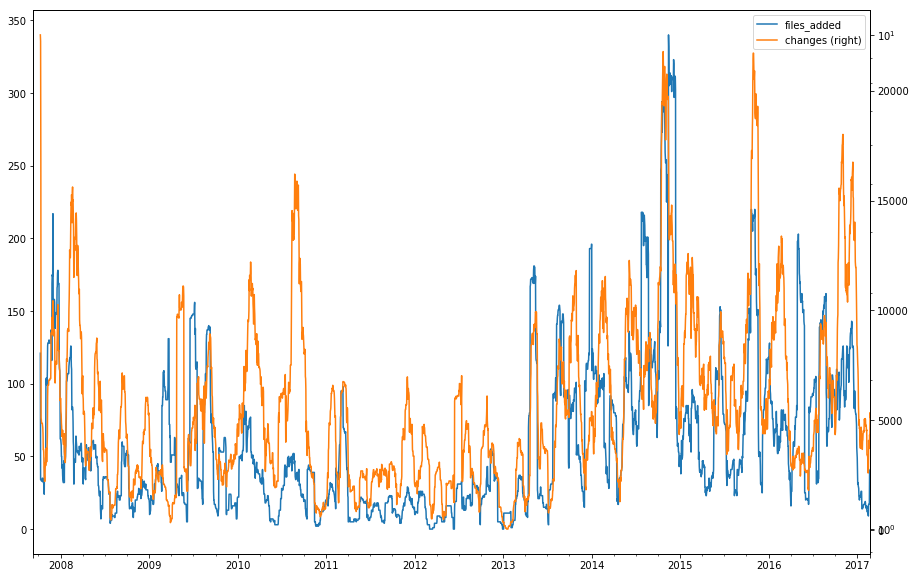

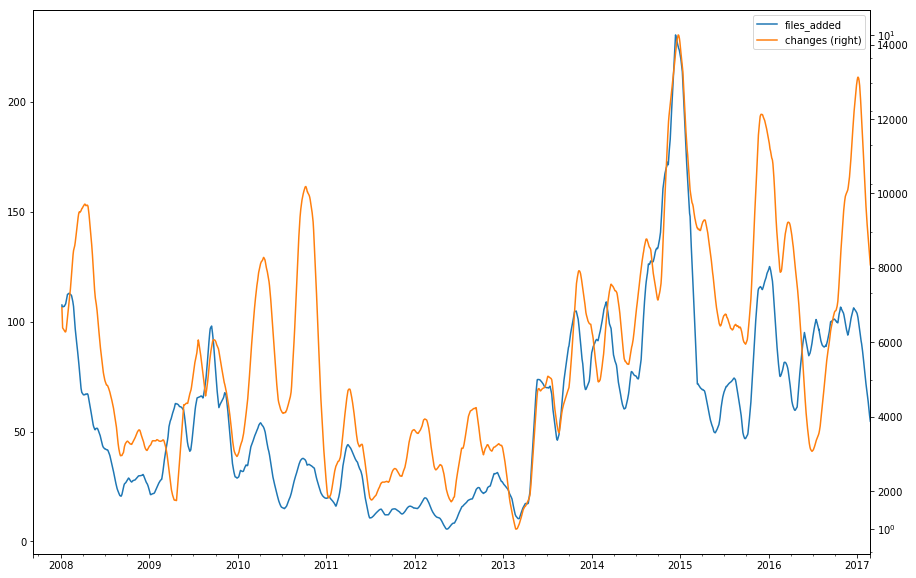

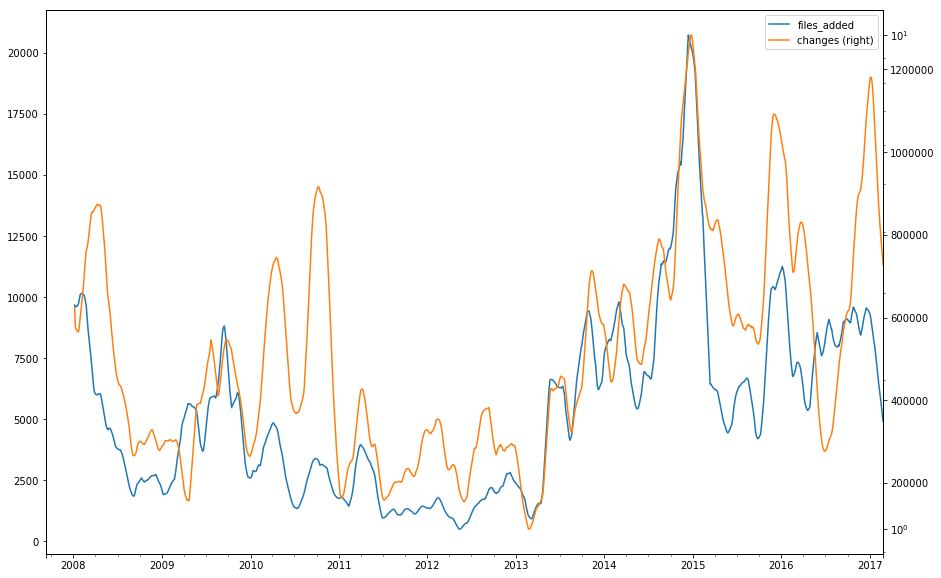

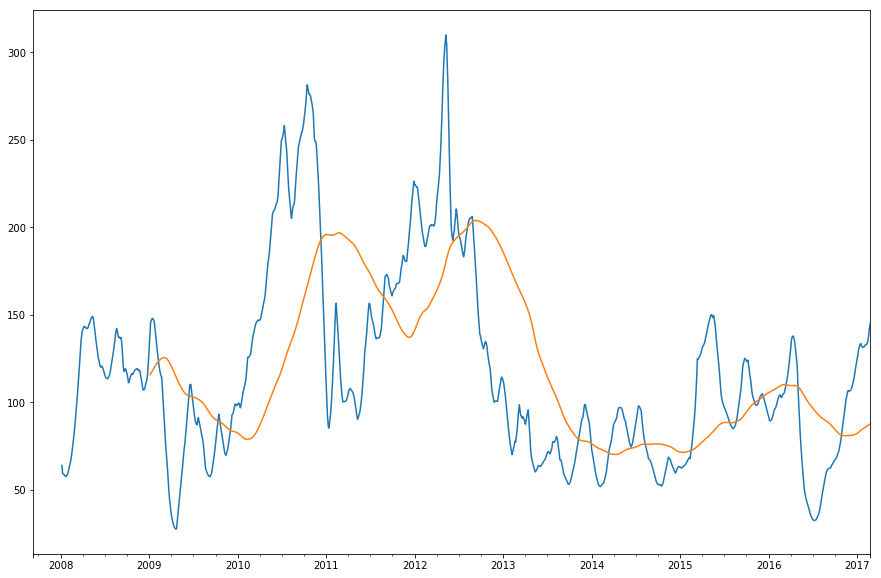

camel


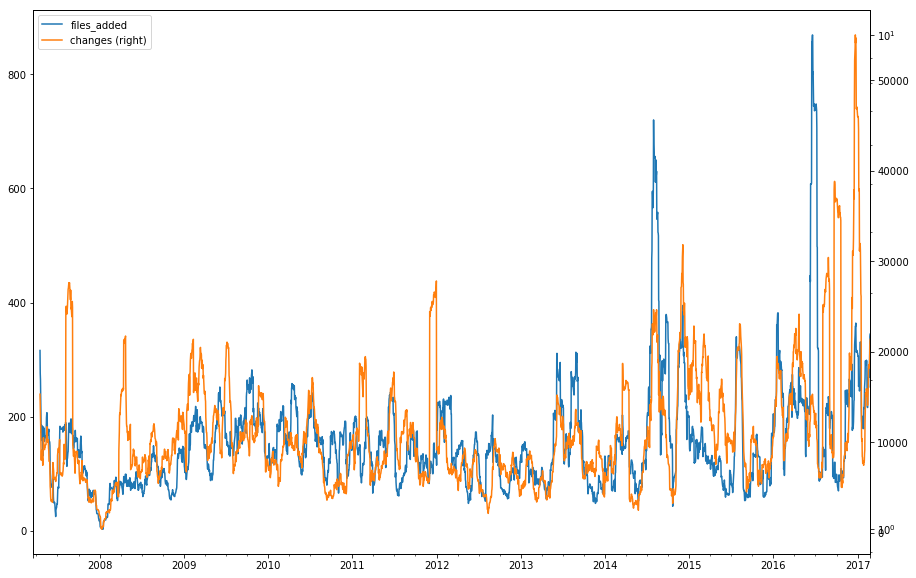

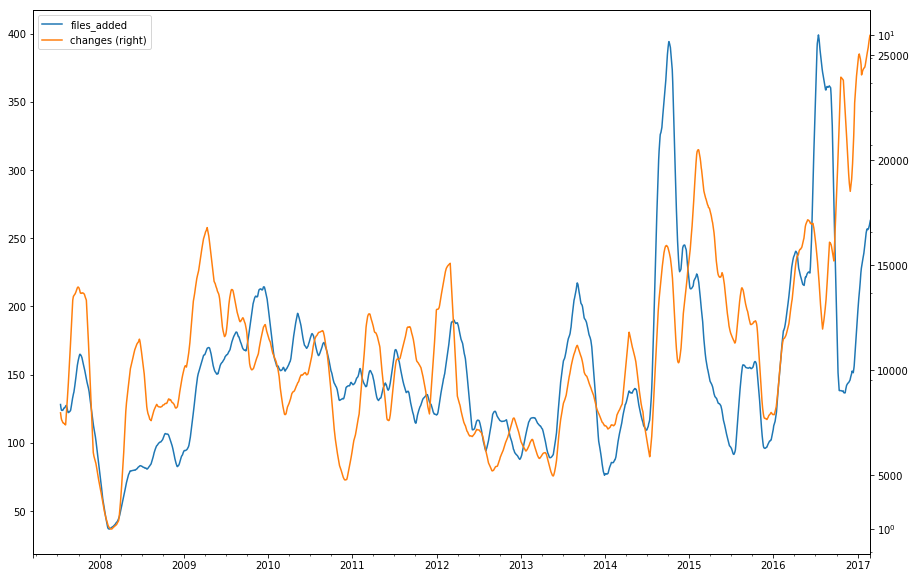

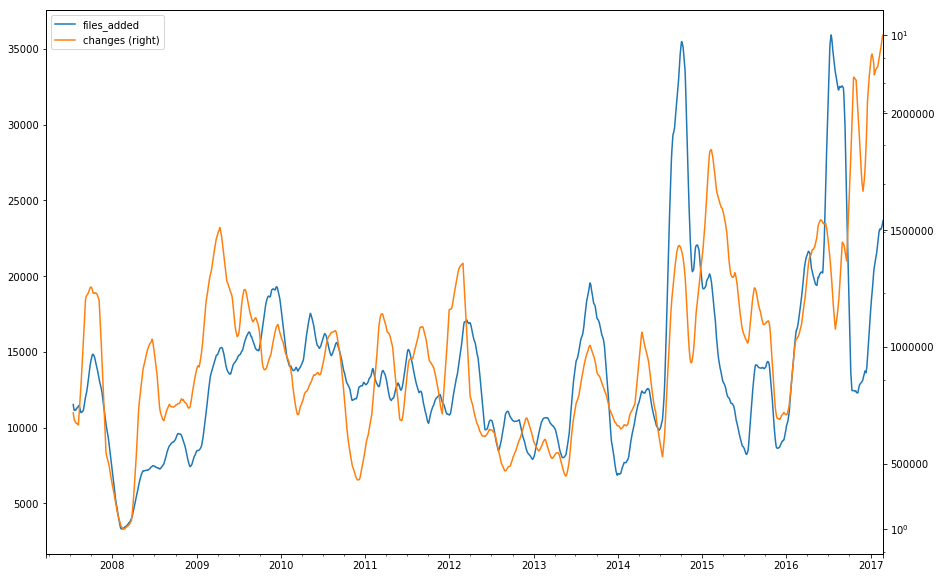

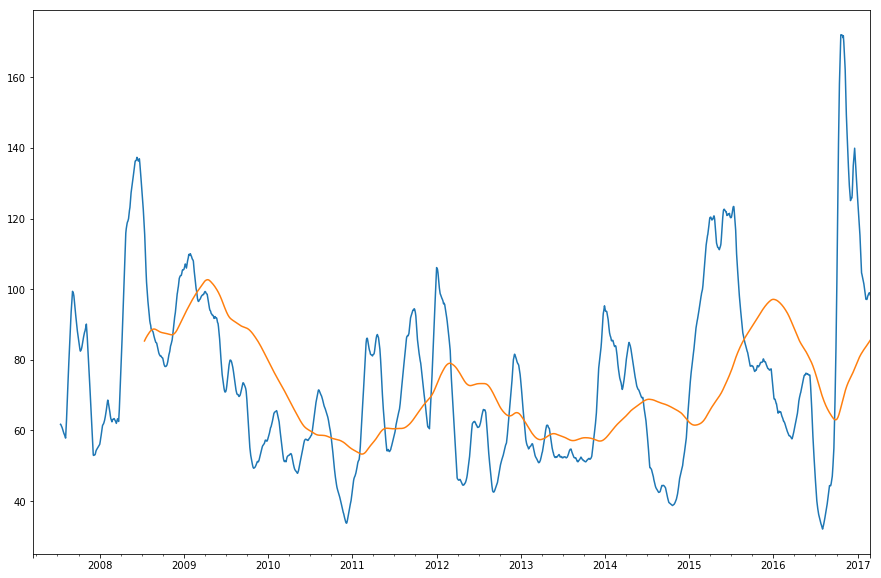

In [6]:
repos = get_repos()
for repo in repos:
    do_commit_analysis(repo)